### Example for a dihedral angle pairs of a biomolecule.

In [5]:
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Implementation of GPR
def get_kernel(sigma):
    def kernel(x0, x1):
        return np.exp(- sigma * ((x0 - x1) ** 2)) # Gaussian kernel
        #return (np.dot(x0,x1) + 1) ** sigma # Polynomial kernel
        #return np.dot(x0,x1) # Linear kernel
    return kernel

In [7]:
def gaussian_process_regression(train_x, train_y, kernel):
    N = len(train_x)
    k = np.zeros(shape=(N, N))
    beta = float(train_y.var())
    h = np.array([])

    for i, bin_num in train_y.iterrows():
        if int(bin_num) > 0:
            h = np.append(h, 1)
        else: h = np.append(h, 0)

    for n0, x0 in train_x.iterrows():
        for n1, x1 in train_x.iterrows():
            k[n0, n1] = kernel(x0, x1)

    noise_matrix = np.eye(N) * beta
    ky = k + noise_matrix
    ky_inv = np.linalg.inv(ky)
    kh0 = h.dot(ky_inv).dot(h.T)
    kh1 = h.T.dot(h) * ky_inv

    a_tilde = (ky_inv - ky_inv * kh1 / kh0).dot(train_y)

    def prediction(x):
        y_new = 0
        for n in range(N):
            y_new += kernel(train_x.iloc[n], x) * a_tilde[n]
        return y_new

    def covariance(x):
        var = 0
        for n in range(N):
            var += kernel(train_x.iloc[n], x) * kernel(train_x.iloc[n], x) * a_tilde[n]
        return np.sqrt(kernel(x, x) - var)
    return prediction, covariance

In [10]:
# Read input files
df_a = pd.read_table('dihedral.dat', delim_whitespace=True, names=['frame', 'a_psi', 'a_phi'])
df_a = df_a[df_a['frame'] != '#Frame'].astype(float).drop(['frame', 'a_phi'], axis=1)

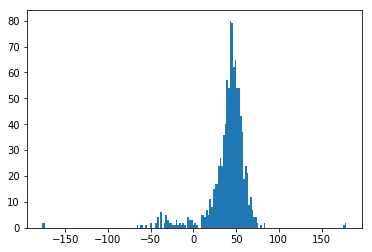

In [12]:
#  Make datasets for training
sample_data = df_a.sample(1000).reset_index(drop=True)
hist = plt.hist(sample_data['a_psi'], bins=180)
mid = np.array([0 for i in range (len(hist[1]) - 1)])

for i, v in enumerate(hist[1]):
    if i != 0:
        mid[i - 1] = (hist[1][i] + hist[1][i - 1]) / 2
mid = mid * (np.pi / 180)

train_y = pd.DataFrame({'y': hist[0]})
train_x = pd.DataFrame({'x': mid})

In [14]:
# Perform GPR
prediction, covariance = gaussian_process_regression(train_x, train_y, get_kernel(50))

Text(0,0.5,'y')

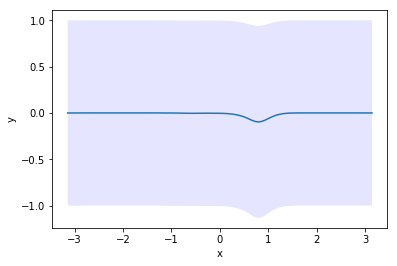

In [16]:
# Make a new dataset
n = 100
test_x = np.linspace(- np.pi, np.pi, n)

# Prediction
test_y = np.array([prediction(i) for i in test_x]).ravel()
test_yerr = np.array([covariance(i) for i in test_x]).ravel()
plt.plot(test_x, test_y)
plt.fill_between(test_x, test_y - test_yerr, test_y + test_yerr, facecolor='b', alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')